## VQE: LiH Simulation

@Phionx @shoumikdc

_Dated: Dec. 15, 2020_

In [2]:
# Imports needed for basic no noise VQE simulation
import numpy as np
import pylab
import copy
from qiskit import BasicAer
from qiskit.aqua import aqua_globals, QuantumInstance
from qiskit.aqua.algorithms import NumPyMinimumEigensolver, VQE
from qiskit.aqua.components.optimizers import SLSQP, SPSA
from qiskit.chemistry.components.initial_states import HartreeFock
from qiskit.chemistry.components.variational_forms import UCCSD
from qiskit.chemistry.drivers import PySCFDriver
from qiskit.chemistry.core import Hamiltonian, QubitMappingType

# Some deprecated package issue; one warning is enough.
import warnings
warnings.filterwarnings(action='once')

In [3]:
molecule = 'H .0 .0 -{0}; Li .0 .0 {0}' # Define molecule; could be H2 or LiH, etc.
distances = np.arange(0.5, 3.75, 0.25) # Distances in Angstrom
vqe_energies = [] 
hf_energies = [] # Hartree-Fock energies
exact_energies = [] # Exact energies from numerical diagonalization

In [4]:
for i, d in enumerate(distances):
    print('step', i)
    
    # initialize driver
    driver = PySCFDriver(molecule.format(d/2), basis='sto3g')
    qmolecule = driver.run()
    operator = Hamiltonian(qubit_mapping=QubitMappingType.PARITY, 
                           two_qubit_reduction=True, freeze_core=True,
                           orbital_reduction=[-3, -2]) # Approxns needed to make this
                                                       # problem tractable.
    
    qubit_op, aux_ops = operator.run(qmolecule)
    
    # exact diagonalization
    exact_result = NumPyMinimumEigensolver(qubit_op, aux_operators=aux_ops).run()
    exact_result = operator.process_algorithm_result(exact_result)
    
    # VQE
    optimizer = SLSQP(maxiter=1000)
    initial_state = HartreeFock(operator.molecule_info['num_orbitals'],
                                operator.molecule_info['num_particles'],
                                qubit_mapping=operator._qubit_mapping,
                                two_qubit_reduction=operator._two_qubit_reduction)
    
    var_form = UCCSD(num_orbitals=operator.molecule_info['num_orbitals'],
                     num_particles=operator.molecule_info['num_particles'],
                     initial_state=initial_state,
                     qubit_mapping=operator._qubit_mapping,
                     two_qubit_reduction=operator._two_qubit_reduction)
    
    algo = VQE(qubit_op, var_form, optimizer, aux_operators=aux_ops)
    
    vqe_result = algo.run(QuantumInstance(BasicAer.get_backend('statevector_simulator')))
    vqe_result = operator.process_algorithm_result(vqe_result)
    
    exact_energies.append(exact_result.energy)
    vqe_energies.append(vqe_result.energy)
    hf_energies.append(vqe_result.hartree_fock_energy)

step 0


<ipython-input-4-72d47f1fb773>:7: DeprecationWarning: The Hamiltonian class is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used.
  operator = Hamiltonian(qubit_mapping=QubitMappingType.PARITY,
/home/shoumikdc/anaconda3/envs/qiskit/lib/python3.8/site-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used to transform QMolecules and construct ground state result objects.
  super().__init__()
/home/shoumikdc/anaconda3/envs/qiskit/lib/python3.8/site-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use

step 1
step 2
step 3
step 4
step 5
step 6
step 7
step 8
step 9
step 10
step 11
step 12
step 13
step 14
step 15
step 16
step 17


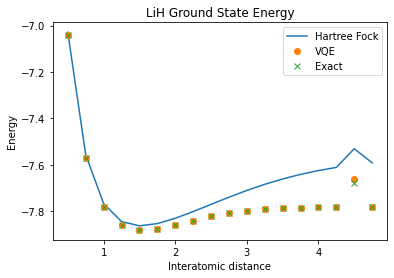

In [5]:
pylab.plot(distances, hf_energies, label='Hartree Fock')
pylab.plot(distances, vqe_energies, 'o', label='VQE')
pylab.plot(distances, exact_energies, 'x', label='Exact')

pylab.xlabel('Interatomic distance')
pylab.ylabel('Energy')
pylab.title('LiH Ground State Energy')
pylab.legend(loc='upper right')

# Uncomment to save plot! 
#pylab.savefig('vqe.png', dpi=300)